In [1]:
## I always import these
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

## relevant for this notebook
import datetime
from dateutil.relativedelta import relativedelta

## python functions written by me that I frequently use
import alexas_functions
alexas_functions.list_my_functions()

the available functions are: 
list_my_functions
test_function
get_filename
get_landsea_mask
extract_region
cc_ev
mask_out_regions
reshape
get_PC_components
dump_into_pickle
open_pickle_data
zonal_avg
Fourier_Analysis
:end of list.


<font size=6> **------------------------- [ FUNCTIONS ] -------------------------**

In [2]:
##################################################################################################################
##################################################################################################################

def get_CMIP_name_list(gen, var_list, exp_list, root='D:\\CMIP_DATA'):
   
    """ PURPOSE: Get a list of CMIP5 or CMIP6 model names that there is data available for. 
        This function returns a list of model names for which data is available for all the 
        inputted variables and experiements. 
        
        gen (str): 'CMIP5' or 'CMIP6'
        var_list (list of str): list of variables ('tas', 'ts', 'psl', 'pr', etc.)
        exp_list (list of str): list of experiments ('historical', 'rcp85', 'ssp585')
        root (str): the directory path to the CMIP data inventory excel file
        
        return Name_List (list of str) 
        """
    
    ## open excel file of inventory lists for CMIP5 or CMIP6 data
    df = pd.read_excel (f'{root}\\data_inventory_{gen}_forpython.xlsx')
    df = df.set_index('Model_Name')
    
    ## the following four lines create a list of length 1 if only one var and/or exp was given
    if type(exp_list)==str:
        exp_list = [exp_list]    
    if type(var_list)==str:
        var_list = [var_list]  
    
    ## initialize the Name_List (NL) 
    NL=np.empty(0)
    
    ## loop through all combinations of variables and experiments 
    for i in range(len(exp_list)):
        for j in range(len(var_list)):
            
            ## get inventory for that specific variable in that experiment
            col_name=f'{var_list[j]}_{exp_list[i]}'
            mname = df[col_name].index.values
            inventory = df[col_name].values

            ## keep ONLY the model names that are marked with an 'x', meaning the data is available
            NL_ij = np.array(mname[inventory=='x'])

            ## add the model names to the list
            NL = np.append(NL, NL_ij)
    
    ## get all the model names, and the number of times each model has the data available
    NL_un, NL_counts = np.unique(NL, return_counts=True)
    
    ## This line keeps only the model names that had the maximum number of occurances
    ## in other words, it keeps the model names that are available across all inputted vars and exp
    Name_List = NL_un[NL_counts==np.max(NL_counts)]
    
    return Name_List

##################################################################################################################
##################################################################################################################

In [3]:
##################################################################################################################
##################################################################################################################

def set_new_time_variable(da_, gen, exp='historical'):
    """
    PURPOSE: create a uniform datetime index for gridded monthly CMIP model output. 
    This code converts them all to numpy.datetime64 type of datetimes. It also utilizes
    builtin datetime function and pandas datatime. This is to deal with the various types of 
    datetime objects that appear in the CMIP output files. 
    This code lines the datetime indices to the correct years for their respective experiement,
    and cuts off projections at the year 2100.
    
    da_ (xr.data_set): the xarray dataset loaded from the cmip model data
    gen (str): 'CMIP5' or 'CMIP6'
    exp (str): the cmip experiment name
    """
    
    ### DETERMINE THE START AND END YEAR AND MONTHS BASED ON THE INPUT DATA 
    
    try: ## this first try works for most datetime objects to extract the year and month
        start_year = da_.time.values[0].year
        start_month = da_.time.values[0].month
    except: ##try to convert the unknown object to a pd datetime object to extract the year and month
        start_year = pd.to_datetime(da_.time.values[0]).year
        start_month = pd.to_datetime(da_.time.values[0]).month
    
    
    ### HISTORICAL 
    ## if the experiment is a CMIP5 or CMIP6 era historical simulation
    if exp=='historical':
        try: ## similar try and except to the above scenario
            end_year = da_.time.values[-1].year
            end_month = da_.time.values[-1].month
        except:
            end_year = pd.to_datetime(da_.time.values[-1]).year
            end_month = pd.to_datetime(da_.time.values[-1]).month
            
        ## some CMIP5 and CMIP6 historical simulations have been extended.
        ## This code snips off the extention to line up with the future projection 
        if end_year > 2005 and gen=='CMIP5':
            end_year = 2005
            end_month =12
            
        if end_year > 2014 and gen=='CMIP6':
            end_year = 2014
            end_month =12
    
    ### PROJECTION
    ## if the experiment is a future emission scenario simulation, such as rcp for v5 and ssp for v6 ,
    ## cut off datetimes to December 2099. The extended simulations tend to behave strangely... 
    elif exp[:3]=='rcp' or exp[:3]=='ssp': ## the prefix for available future simulation labels 
        end_year = 2099
        end_month = 12    
    
    
    ## INITIALIZE the timestamps for the new datetime object
    ts1 = datetime.datetime(start_year, start_month, 15, 12, 0, 0)
    tsE = datetime.datetime(end_year, end_month, 15, 12, 0, 0)
    
    print(exp, ts1, tsE)
    
    ## create an array of incremental monthly datetime objects, from start year through the length of the 
    ## original monthly time series 
    all_times = [ts1 + relativedelta(months=a_month) for a_month in range(len(da_.time))]
    
    ## set the time variable in the xarray dataset to the new time series
    da_['time']=all_times
    
    ## slice the entire xarray dataset to the standard start and end years,months 
    da_ = da_.sel(time=slice(ts1, tsE))

    ## convert the datetime objects into numpy.datetime64 objects if they aren't already
    if type(da_['time'].values[0]) != type(np.datetime64(all_times[0])):
        da_['time'] =  [np.datetime64(da_['time'].values[i]) for i in range(len(da_.time))] 
        ## this list comprehension converts each datetime.datetime into a np.datetime64
    
    ## return the entire xarray dataset, with the updated and trimmed time series index
    return da_

##################################################################################################################
##################################################################################################################

<font size=6> **----------------------------- [ MAIN ] -----------------------------**

In [4]:
##### Inititalize looping variables here #####

## these are defaults I've set up... 
## Comment out one block or the other

# ########################################################################
# gen='CMIP6'
# var='tas'
# exp=['historical', 'ssp585']
# merge_exp = True
# CMIP6_tas_NL = get_CMIP_name_list(gen, var_list, exp_list)
# Name_List = CMIP6_tas_Name_List
# ########################################################################

########################################################################
gen='CMIP5'
var_list=['tas']
exp_list=['historical', 'rcp85']
merge_exp = True
CMIP5_tas_NL = get_CMIP_name_list(gen, var_list, exp_list)
Name_List = CMIP5_tas_NL
########################################################################

tas
ACCESS1-0
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


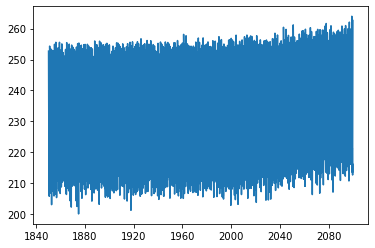

ACCESS1-3
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


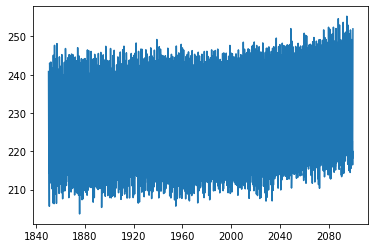

CMCC-CESM
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2000-01-15 12:00:00 2099-12-15 12:00:00


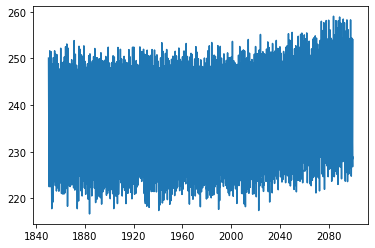

CMCC-CM
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


C:\Users\alexa\Anaconda3\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


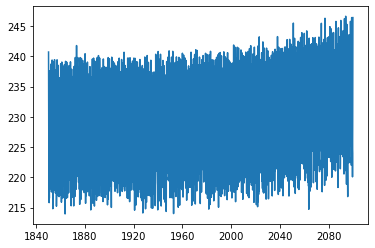

CMCC-CMS
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


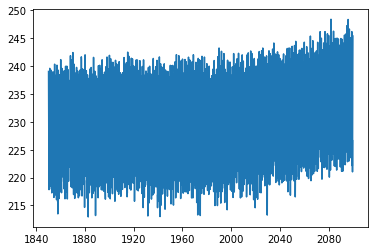

CNRM-CM5
historical 1850-01-15 12:00:00 2005-12-15 12:00:00


C:\Users\alexa\Anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\alexa\Anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\alexa\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


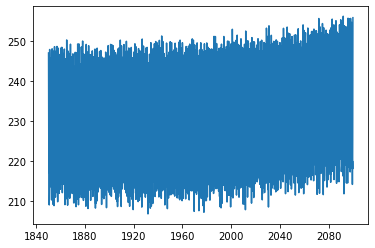

CSIRO-Mk3-6-0
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


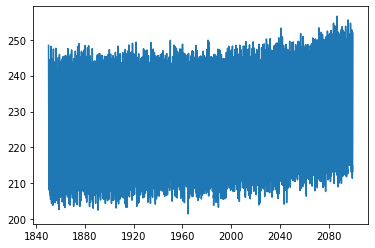

CanESM2
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


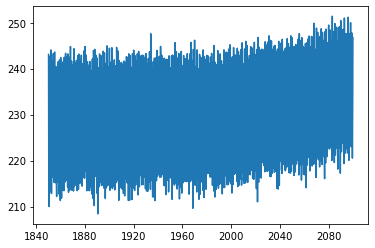

FGOALS-s2
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


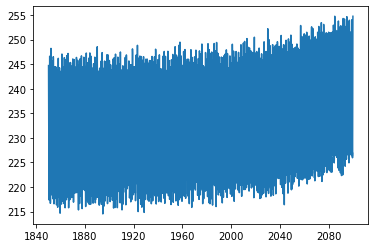

GFDL-CM3
historical 1860-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


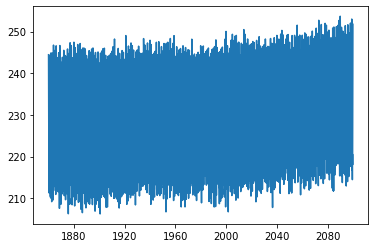

GFDL-ESM2G
historical 1861-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


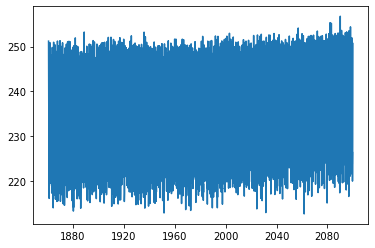

GFDL-ESM2M
historical 1861-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


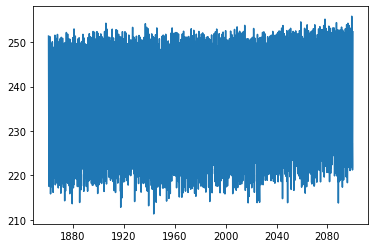

GISS-E2-H
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


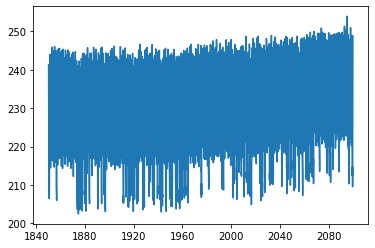

GISS-E2-H-CC
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


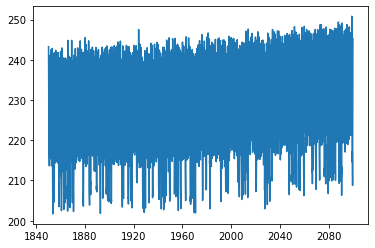

GISS-E2-R
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


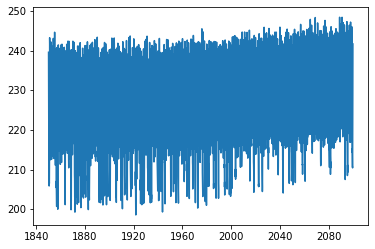

GISS-E2-R-CC
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


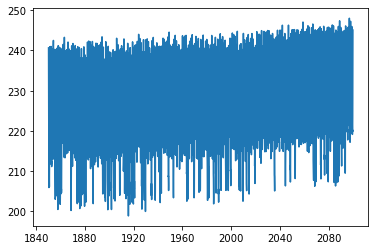

HadGEM2-AO
historical 1860-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


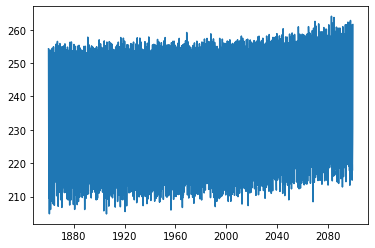

HadGEM2-CC
historical 1859-12-15 12:00:00 2005-11-15 12:00:00
rcp85 2005-12-15 12:00:00 2099-12-15 12:00:00


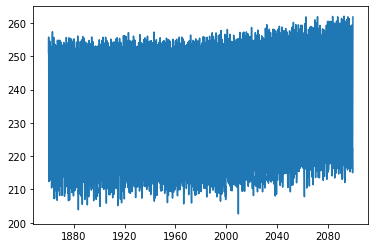

HadGEM2-ES
historical 1859-12-15 12:00:00 2005-11-15 12:00:00
rcp85 2005-12-15 12:00:00 2099-12-15 12:00:00


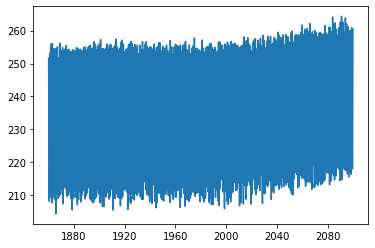

IPSL-CM5A-LR
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


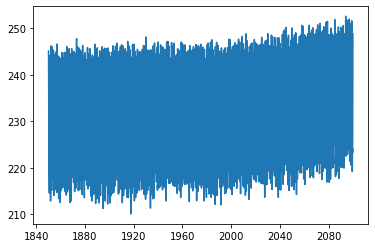

IPSL-CM5A-MR
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


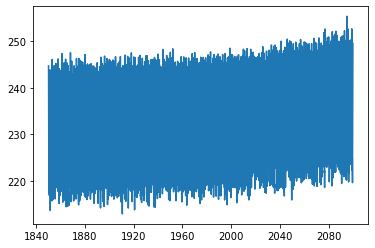

IPSL-CM5B-LR
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


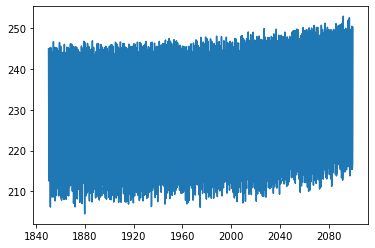

MIROC-ESM
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


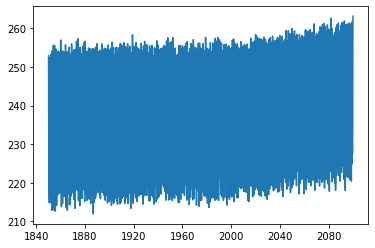

MIROC-ESM-CHEM
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


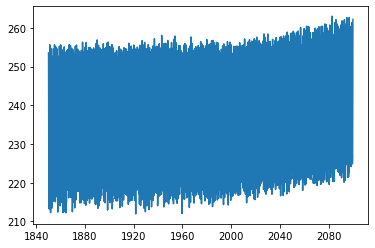

MIROC5
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00
!!!!!! --- Warning --- !!!!!!
output from the two experiments CANNOT BE MERGED due to incompatible grid resolution
....SKIPPING to next in the loop.
!!!!!!
MPI-ESM-LR
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


C:\Users\alexa\Anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\alexa\Anaconda3\lib\site-packages\xarray\coding\times.py:427: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
C:\Users\alexa\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


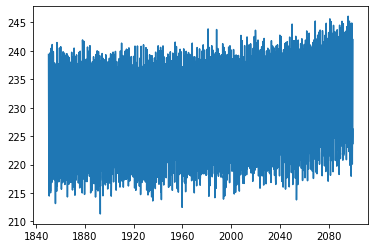

MPI-ESM-MR
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


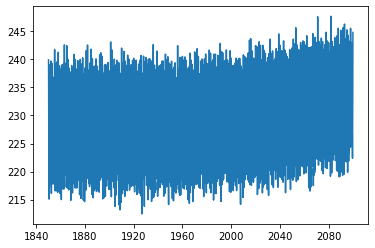

MRI-CGCM3
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


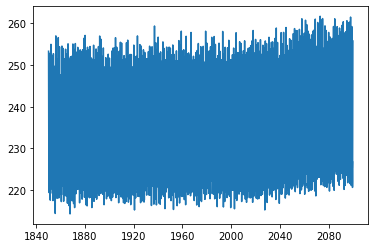

MRI-ESM1
historical 1851-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


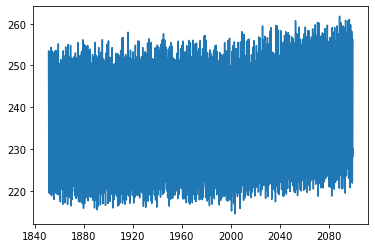

NorESM1-M
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


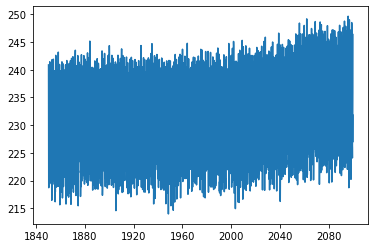

NorESM1-ME
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


C:\Users\alexa\Anaconda3\lib\site-packages\xarray\core\indexing.py:1361: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


!!!!!! --- Warning --- !!!!!!
output from the two experiments CANNOT BE MERGED due to incompatible grid resolution
....SKIPPING to next in the loop.
!!!!!!
inmcm4
historical 1850-01-15 12:00:00 2005-12-15 12:00:00
rcp85 2006-01-15 12:00:00 2099-12-15 12:00:00


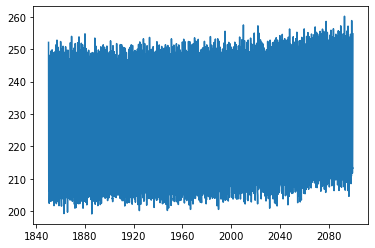

In [6]:
## note: the following code works for (len(exp_list)==1 and merge_exp==False) or (len(exp_list)==2 and merge_exp==True)
## the order of the loops and the if merge_exp == True statements would need to be reordered for other scenarios

##### begin looping through all variables here.
for v in range(len(var_list)):
    var = var_list[v]
    print(var)

    ##### begin looping through all CMIP5(6) names for a single variable here.
    for i in range(0, len(Name_List)):
        print(Name_List[i])

        ## get full filename/location of data for a given model/variable/experiement
        filename_tas1 = alexas_functions.get_filename(gen, var, name=Name_List[i], root='D:\\CMIP_DATA', exp=exp_list[0])

        ## open data into an xarray file
        ## some models have more than one file because the data is outputted into incremental chunks
        da1 = xr.open_mfdataset(filename_tas1) 
        ## send to new time variable function to create uniform time series 
        da1 = set_new_time_variable(da1, gen)
        da1.close() ## close the file that was just opened 

        ## to merge two experiment runs together (such as historical + rcp8.5)
        if merge_exp == True: 
            filename_tas2 = alexas_functions.get_filename(gen, var, name=Name_List[i],root='D:\\CMIP_DATA', exp=exp_list[1])
            da2 = xr.open_mfdataset(filename_tas2)
            da2 = set_new_time_variable(da2, gen, exp=exp_list[1])
            da2.close()

            ## try to merge the files 
            ## in most cases, it seamlessly merges them along the time axis
            try:        
                da = xr.merge([da1,da2])
                open_success = True

            ## this generally occurs if the two experiements are on different grids (different shape())
            ## there may be a way to fix or work around this, but it is not a simple solution
            except xr.MergeError: ## xarray merge error 
                print('!!!!!! --- Warning --- !!!!!!')
                print('output from the two experiments CANNOT BE MERGED due to incompatible grid resolution')
                print('....SKIPPING to next in the loop.\n!!!!!!')
                open_success = False
                ## the below code works if the 'lat_bnds' are the same shape but contain different numbers 
                ## which implies they are on a different grid projection... better to just skip at this point 
                # da2['lat_bnds'].values = da1['lat_bnds'].values       
                # da = xr.merge([da1,da2])

        ## if not wanting to or are unable merge experiments together 
        elif merge_exp == False:
            da=da1 
        
        ## this is a simple, non-comprehensive check that the data opened and looks correct
        if open_success==True:
            plt.plot(da.time, da.isel(lat=0,lon=0)[var])
            plt.show()

<font size=4.5> The functions *set_new_time_variable* and *get_CMIP_name_list* will be assimilated into **alexas_function.py** 